In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt 

if not torch.cuda.is_available():
    raise Exception("You should enagle GPU in the Runtime menu")
device = torch.device("cuda")

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-tLBJFvpnz7Fo2umGbUQsJounvoyfMKt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-tLBJFvpnz7Fo2umGbUQsJounvoyfMKt" -O dogs-vs-cats.zip && rm -rf /tmp/cookies.txt

--2020-10-20 17:23:04--  https://docs.google.com/uc?export=download&confirm=CSM_&id=1-tLBJFvpnz7Fo2umGbUQsJounvoyfMKt
Resolving docs.google.com (docs.google.com)... 108.177.97.102, 108.177.97.101, 108.177.97.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-7o-docs.googleusercontent.com/docs/securesc/43je3241fn9hr47guj1o8tob06ql15k3/tklb4htl3lsnv1j2pv4v31ufd619g478/1603214550000/01551550992184339031/14098588336328572927Z/1-tLBJFvpnz7Fo2umGbUQsJounvoyfMKt?e=download [following]
--2020-10-20 17:23:05--  https://doc-14-7o-docs.googleusercontent.com/docs/securesc/43je3241fn9hr47guj1o8tob06ql15k3/tklb4htl3lsnv1j2pv4v31ufd619g478/1603214550000/01551550992184339031/14098588336328572927Z/1-tLBJFvpnz7Fo2umGbUQsJounvoyfMKt?e=download
Resolving doc-14-7o-docs.googleusercontent.com (doc-14-7o-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting

In [ ]:
!unzip -qq dogs-vs-cats.zip -d dogs-vs-cats/
!unzip -qq dogs-vs-cats/train.zip -d /datalab/

replace dogs-vs-cats/sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace /datalab/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os, shutil
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/datalab/train/'

# The directory where we will
# store our smaller dataset
base_dir = '/content/processed_datalab'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 500 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(200, 400)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 500 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(200, 400)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 200
total training dog images: 200
total validation cat images: 200
total validation dog images: 200


## Building our network
### Exercise 1

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPool2D` layers.

Here, since we start from inputs of size 150x150 (a  somewhat arbitrary choice), and we want to end up with feature maps of size 7x7 right before the `Flatten` layer.

**Exercise:** Write the definition of the model using 4 convolutional layers with kernel size 3x3. The last convolutional layers should have about 256 kernels. With the three `MaxPool2D` layers,  the final size will be 7x7. At the end, add 2 fully-connected layers for binary classification with 512 hidden units.



In [ ]:
model = nn.Sequential(  # [3, 150, 150]
    nn.Conv2d(3, 32, 3),  # [32, 148, 148]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [32, 74, 74]
    nn.Conv2d(32, 64, 3),  # [64, 72, 72]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [64, 36, 36]
    nn.Conv2d(64, 128, 3),  # [128, 34, 34]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [128, 17, 17]
    nn.Conv2d(128, 256, 3),  # [256, 15, 15]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [256, 7, 7]
    nn.Flatten(),
    nn.Linear(256*7*7, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
)

model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten()
  (13): Linear(in_features=12544, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()


In [ ]:
transform = transforms.Compose([
                      transforms.Resize(150),
                      transforms.CenterCrop(150),
                      transforms.ToTensor(),
])

In [ ]:
train_dir

'/content/processed_datalab/train'

In [ ]:
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(validation_dir, transform=transform)


In [ ]:
train_dataset[0]

(tensor([[[0.9529, 0.9569, 0.9608,  ..., 0.9765, 0.9725, 0.9725],
          [0.9529, 0.9569, 0.9608,  ..., 0.9765, 0.9765, 0.9765],
          [0.9529, 0.9569, 0.9608,  ..., 0.9765, 0.9804, 0.9804],
          ...,
          [0.2667, 0.2431, 0.2549,  ..., 0.0706, 0.0588, 0.0471],
          [0.2706, 0.2314, 0.2392,  ..., 0.0392, 0.0392, 0.0314],
          [0.2706, 0.2235, 0.2275,  ..., 0.0235, 0.0275, 0.0235]],
 
         [[0.7843, 0.7882, 0.7922,  ..., 0.9020, 0.8980, 0.8941],
          [0.7843, 0.7882, 0.7922,  ..., 0.9020, 0.9020, 0.8980],
          [0.7843, 0.7882, 0.7922,  ..., 0.9020, 0.9059, 0.9020],
          ...,
          [0.2000, 0.1765, 0.1843,  ..., 0.0588, 0.0471, 0.0431],
          [0.2078, 0.1725, 0.1765,  ..., 0.0392, 0.0431, 0.0353],
          [0.2078, 0.1647, 0.1647,  ..., 0.0235, 0.0314, 0.0275]],
 
         [[0.4745, 0.4784, 0.4824,  ..., 0.6039, 0.6039, 0.6078],
          [0.4745, 0.4784, 0.4824,  ..., 0.6039, 0.6078, 0.6118],
          [0.4745, 0.4784, 0.4824,  ...,

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_model(model, optimizer, criterion, train_loader, val_loader, epochs):

    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    train_loss = AverageMeter()
    train_accuracy = AverageMeter()

    for epoch in range(epochs):
        # train
        model.train()
        train_loss.reset()
        train_accuracy.reset()
        train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
        for data, target in train_loop:
            train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, epochs))
            data, target = data.float().to(device), target.float().to(device)
            target = target.unsqueeze(-1)
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss.update(loss.item(), n=len(target))
            pred = torch.sigmoid(output).round()  # get the prediction
            acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
            train_accuracy.update(acc, n=len(target))
            train_loop.set_postfix(loss=train_loss.avg, accuracy=train_accuracy.avg)

        train_losses.append(train_loss.avg)
        train_accuracies.append(train_accuracy.avg)

        # validation
        model.eval()
        val_loss.reset()
        val_accuracy.reset()
        val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
        with torch.no_grad():
            for data, target in val_loop:
                val_loop.set_description('[VAL] Epoch {}/{}'.format(epoch + 1, epochs))
                data, target = data.float().to(device), target.float().to(device)
                target = target.unsqueeze(-1)
                output = model(data)
                loss = criterion(output, target)
                val_loss.update(loss.item(), n=len(target))
                pred = torch.sigmoid(output).round()  # get the prediction
                acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
                val_accuracy.update(acc, n=len(target))
                val_loop.set_postfix(loss=val_loss.avg, accuracy=val_accuracy.avg)

        val_losses.append(val_loss.avg)
        val_accuracies.append(val_accuracy.avg)
        
    return train_accuracies, train_losses, val_accuracies, val_losses


In [ ]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


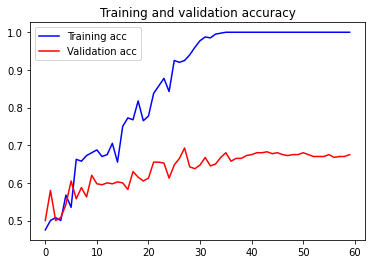

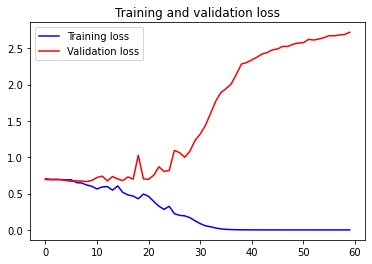

In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Avoid Overfitting

### Data augmentation

In [ ]:
train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(150),
                                transforms.ToTensor(),
])
val_transform = transforms.Compose([
                      transforms.Resize(150),
                      transforms.CenterCrop(150),
                      transforms.ToTensor(),
])

In [ ]:
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(validation_dir, transform=val_transform)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


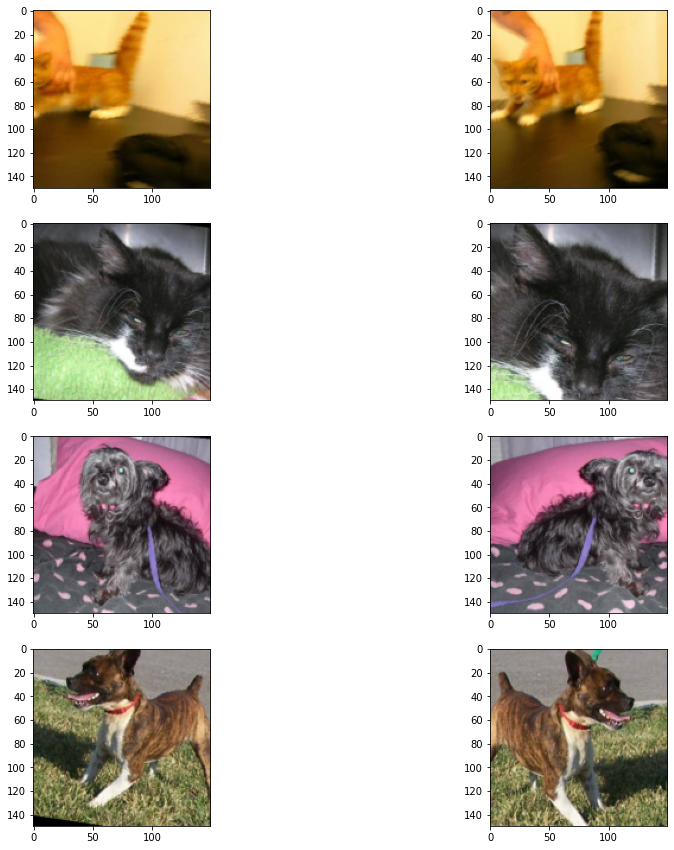

In [ ]:
random_indices = [0, 42, 200, 242]
augmented_images = [train_dataset[i][0] for i in random_indices]
augmented_images = [np.asarray(transforms.functional.to_pil_image(im)) for im in augmented_images]

images = [train_dataset[i][0] for i in random_indices]
images = [np.asarray(transforms.functional.to_pil_image(im)) for im in images]

fig, axes = plt.subplots(len(random_indices), 2, figsize=(15, 15))
for i in range(len(random_indices)):
    axes[i, 0].imshow(images[i])
    axes[i, 1].imshow(augmented_images[i])

### Exercise 2

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, you should add a Dropout layer to our model, right before the densely-connected classifier layers:

In [ ]:
model = nn.Sequential(  # [3, 150, 150]
    nn.Conv2d(3, 32, 3),  # [32, 148, 148]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [32, 74, 74]
    nn.Conv2d(32, 64, 3),  # [64, 72, 72]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [64, 36, 36]
    nn.Conv2d(64, 128, 3),  # [128, 34, 34]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [128, 17, 17]
    nn.Conv2d(128, 256, 3),  # [256, 15, 15]
    nn.ReLU(),
    nn.MaxPool2d(2),  # [256, 7, 7]
    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(256*7*7, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
)

model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=12544, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()


In [ ]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, epochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f00f1cf7c88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f00f1cf7c88>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 1

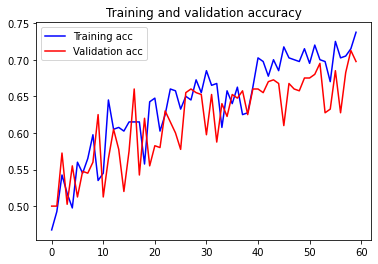

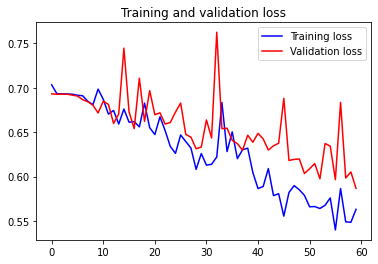

In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from torchvision.models import vgg16

pretrained_model = vgg16(pretrained=True)
pretrained_model.eval()
pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
feature_extractor = pretrained_model.features
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
def extract_features(path):
    transform = transforms.Compose([
                               transforms.Resize(150),
                               transforms.CenterCrop(150),
                               transforms.ToTensor(),
    ])
    dataset = ImageFolder(path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=4)
    features = []
    labels = []
    with torch.no_grad():
        for image_batch, label_batch in dataloader:
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)
            features_batch = feature_extractor(image_batch)
            features.append(features_batch)
            labels.append(label_batch)
    features_tensor = torch.cat(features, dim=0)
    labels_tensor = torch.cat(labels, dim=0)

    return features_tensor, labels_tensor

In [ ]:
train_features, train_labels = extract_features(train_dir)
validation_features, validation_labels = extract_features(validation_dir)


In [ ]:
train_features = torch.flatten(train_features, start_dim=1)
validation_features = torch.flatten(validation_features, start_dim=1)
train_features.shape

torch.Size([400, 8192])

### Exercise 3
At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded.
**Exercise:** define the densely-connected classifier with input dim 4x4x512, 256 hidden units and dropout 0.5.


In [ ]:
feature_classifier = nn.Sequential(
    nn.Linear(4*4*512, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, 1),
)

feature_classifier.to(device)

Sequential(
  (0): Linear(in_features=8192, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.Adam(feature_classifier.parameters())
criterion = nn.BCEWithLogitsLoss()

In [ ]:
from torch.utils.data import TensorDataset

batch_size = 64
train_dataset = TensorDataset(train_features.cpu(), train_labels.cpu())
validation_dataset = TensorDataset(validation_features.cpu(), validation_labels.cpu())


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)


In [ ]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(feature_classifier, optimizer, criterion, train_loader, val_loader, epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


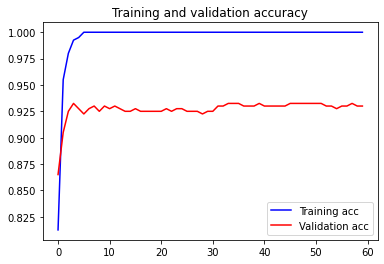

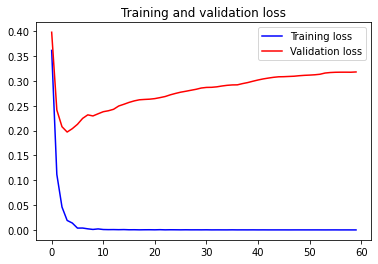

In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine Tuning

#### Exercise 4

Get a feature extractor from a pretrained VGG16 as before.

In [ ]:
pretrained_model = vgg16(pretrained=True)
pretrained_model.to(device)
feature_extractor = pretrained_model.features
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
for layer in feature_extractor[0:24]:
    for parameter in layer.parameters():
        parameter.requires_grad = False

for layer in feature_extractor[24:]:
    for parameter in layer.parameters():
        parameter.requires_grad = True

### Exercise 5
Create a model with the `feature_classifier` on top of the `feature_extrator`. Note that you will need to flatten the features. 

In [ ]:
class FineTuneModel(nn.Module):
    def __init__(self, feature_extractor, feature_classifier):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.feature_classifier = feature_classifier

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x = self.feature_classifier(x)
        return x
        
model = FineTuneModel(feature_extractor, feature_classifier)
model.to(device)


FineTuneModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

In [ ]:
model = nn.Sequential(    
    feature_extractor,
    nn.Flatten(),
    feature_classifier,
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(10), 
                                      transforms.RandomResizedCrop(150), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(150), 
                                    transforms.CenterCrop(150), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(validation_dir, transform=val_transform)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# optimizer = optim.Adam({"extractor": model[0].parameters(),
#                         "classifier": model[2].parameters()}, 
#                        {"extractor": 1e-4,
#                         "classifier": 1e-3})


In [ ]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, epochs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
len(list(model.parameters()))

30

In [ ]:
sum(p.numel() for p in model.parameters())

16812353

In [ ]:
sum(p.numel() for p in model.parameters())*32/8/1024/1024


64.13403701782227

In [ ]:
class FineTuneModel(nn.Module):
    def __init__(self, feature_extractor, feature_classifier):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.fc = nn.Linear(100, 200)
        self.feature_classifier = feature_classifier

    def forward(self, x, tabular):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        z = self.fc(tabular)
        features = torch.cat(x, z)
        y = self.feature_classifier(features)
        return y
        
model = FineTuneModel(feature_extractor, feature_classifier)
model.to(device)
